Goal fo this EDA:
- To figure out ways to accuratly count family size in the census data
- To create some preliminary plots on how family size changes over times

In [1]:
# imports
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import plotly.graph_objs as go
import json
from typing import List, Any, Dict

from helper_functions import clean_data_age_gender, split_csv, calculate_household_stats

#Future proofing of the way we use pandas
pd.options.mode.copy_on_write = True

In [2]:
# import test data
census_data_dir = Path.cwd().parent / 'data' / 'census'

# we load in the first of the census to explore that data
first_census_df = pd.read_csv(census_data_dir / "copenhagen" / 'Rigsarkivet_folketælling_Kobenhavn_amt_1787.csv', delimiter='$')

# We still clean the age and sex coloumns for now
cleaned_census_df, _, _ = clean_data_age_gender(first_census_df)

In [3]:
# calculate household sizes
household_sizes: pd.Series = cleaned_census_df['household_id'].value_counts()

average_household_size = household_sizes.mean()
average_household_size

np.float64(4.899370244030438)

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2877331560.py:5: DtypeWarning: Columns (2,3,4,22,23,24,26,27,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2877331560.py:5: DtypeWarning: Columns (16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2877331560.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2877331560.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  census_df = pd.read_csv(census, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000g

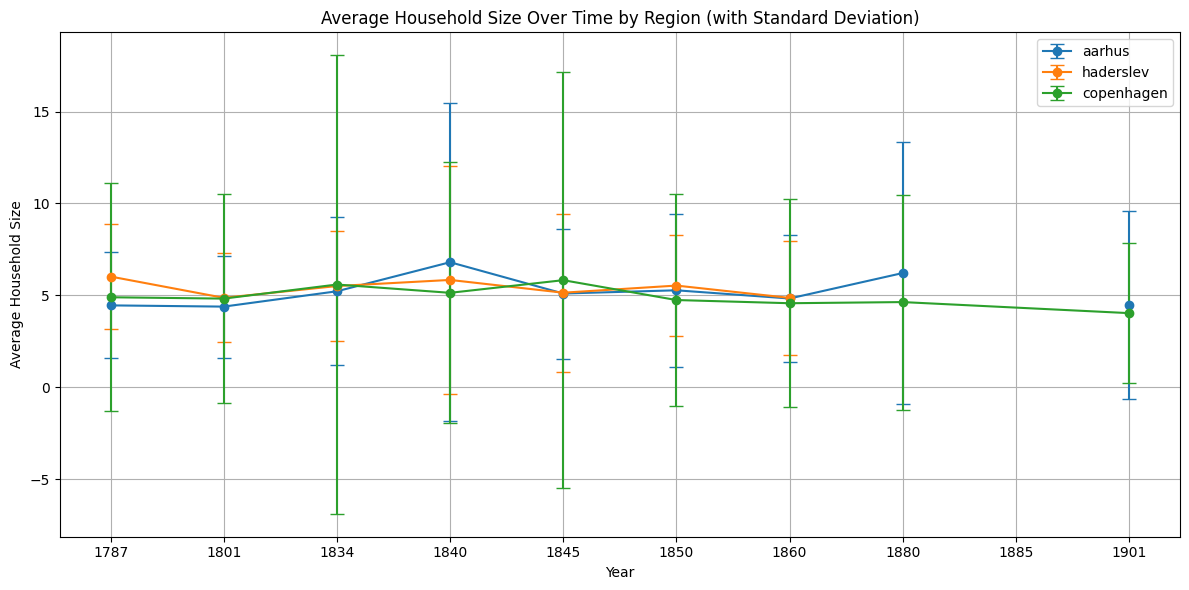

In [4]:
household_size_dict = {}
for dir in census_data_dir.iterdir():
    household_size_dict[dir.name] = {}
    for census in dir.iterdir():
        census_df = pd.read_csv(census, delimiter='$')
        cleaned_census_df, _, _ = clean_data_age_gender(census_df)
        results_dict = calculate_household_stats(cleaned_census_df)
        household_size_dict[dir.name][census.stem.split('_')[-1]] = results_dict

plt.figure(figsize=(12, 6))

for region, values in household_size_dict.items():
    years = sorted(values.keys())
    sizes = [values[year]["average_family_size"] for year in years]
    errors = [values[year]['std_family_size'] for year in years]
    plt.errorbar(years, sizes, yerr=errors, marker='o', capsize=5, label=region)

plt.xlabel('Year')
plt.ylabel('Average Household Size')
plt.title('Average Household Size Over Time by Region (with Standard Deviation)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/3931207618.py:7: DtypeWarning: Columns (2,3,4,22,23,24,26,27,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/3931207618.py:7: DtypeWarning: Columns (16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/3931207618.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/3931207618.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_14

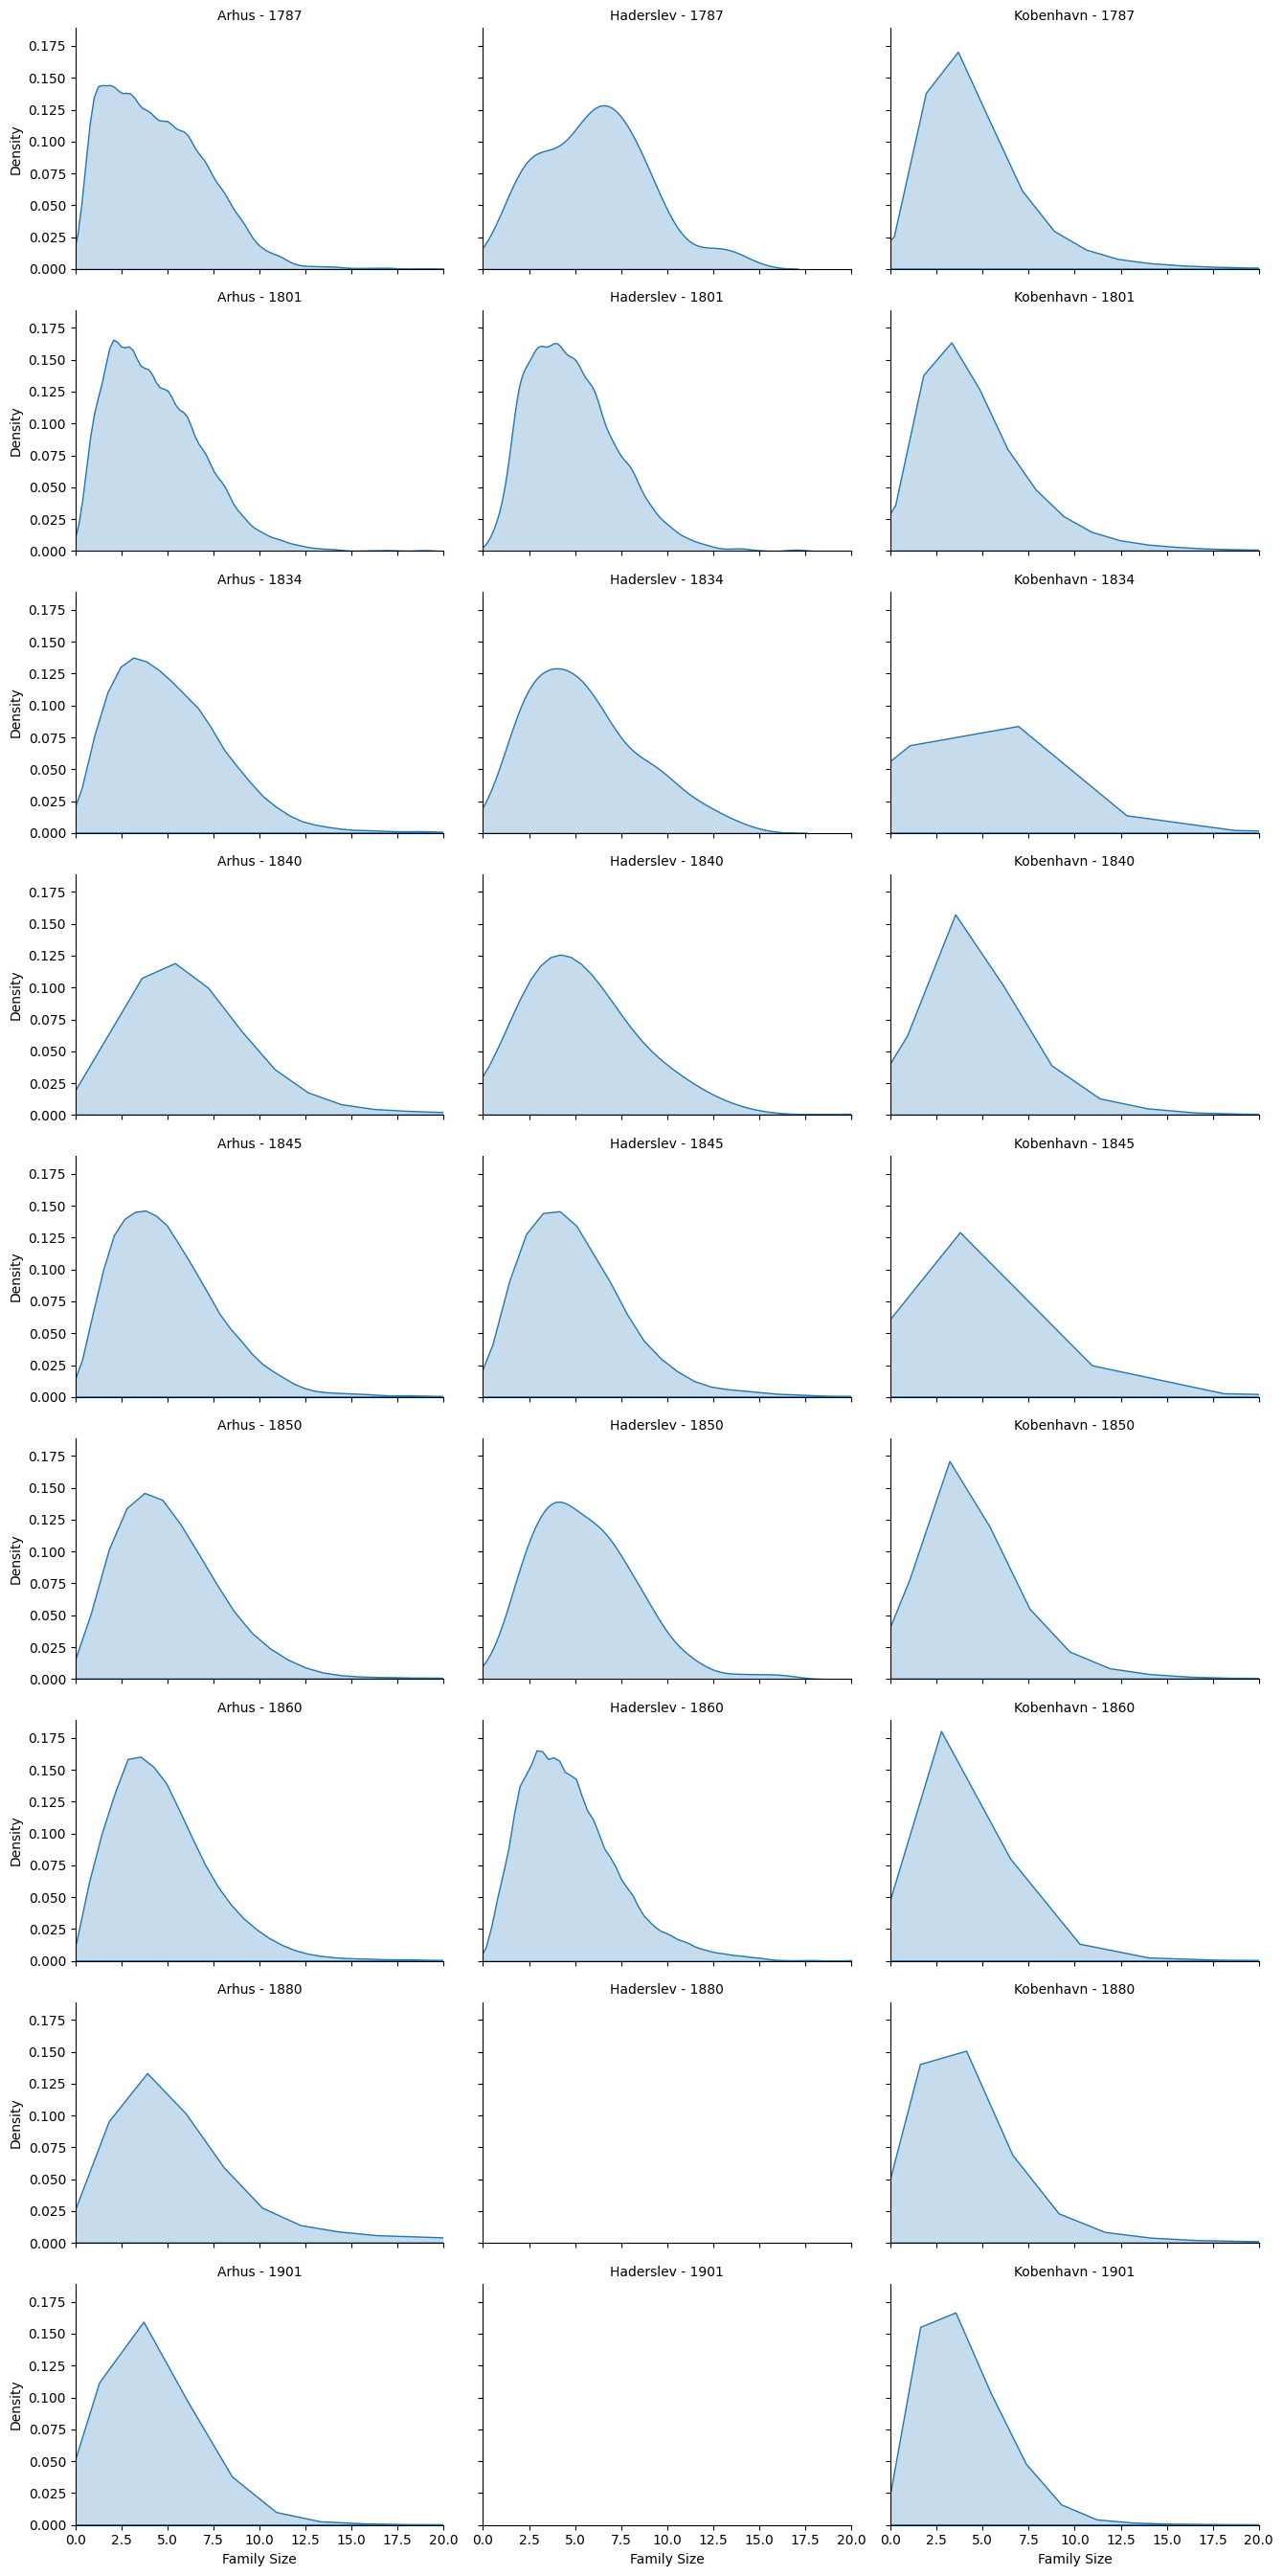

In [5]:
csv_files = census_data_dir.glob('*/Rigsarkivet_folketælling*.csv')

# Function to process each file and extract family size
def process_file(file_path: Path) -> pd.DataFrame:
    if isinstance(file_path, str):
        file_path = Path(file_path)
    df = pd.read_csv(file_path, delimiter='$')
    year = int(str(file_path.stem).split('_')[-1].split('.')[0])  # Extract year from filename
    amt = str(file_path.stem).split('_')[2]  # Extract amt from filename
    
    # Group by household_id and count family members
    family_sizes = df.groupby('household_id').size().reset_index(name='family_size')
    family_sizes['year'] = year
    family_sizes['amt'] = amt
    
    return family_sizes

# Process all files
all_family_sizes = pd.concat([process_file(file) for file in csv_files])

# Create the facet plot
g = sns.FacetGrid(all_family_sizes, col="amt", row="year", height=3, aspect=1.5)
g.map(sns.kdeplot, "family_size", fill=True)
g.set(xlim=(0, 20))
g.set_axis_labels("Family Size", "Density")
g.set_titles("{col_name} - {row_name}")

plt.tight_layout()
plt.show()

/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2896090201.py:21: DtypeWarning: Columns (2,3,4,22,23,24,26,27,28,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2896090201.py:21: DtypeWarning: Columns (16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2896090201.py:21: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykernel_1411/2896090201.py:21: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter='$')
/var/folders/xr/n973hf0s243g7hdvvvh5kzmr0000gn/T/ipykerne

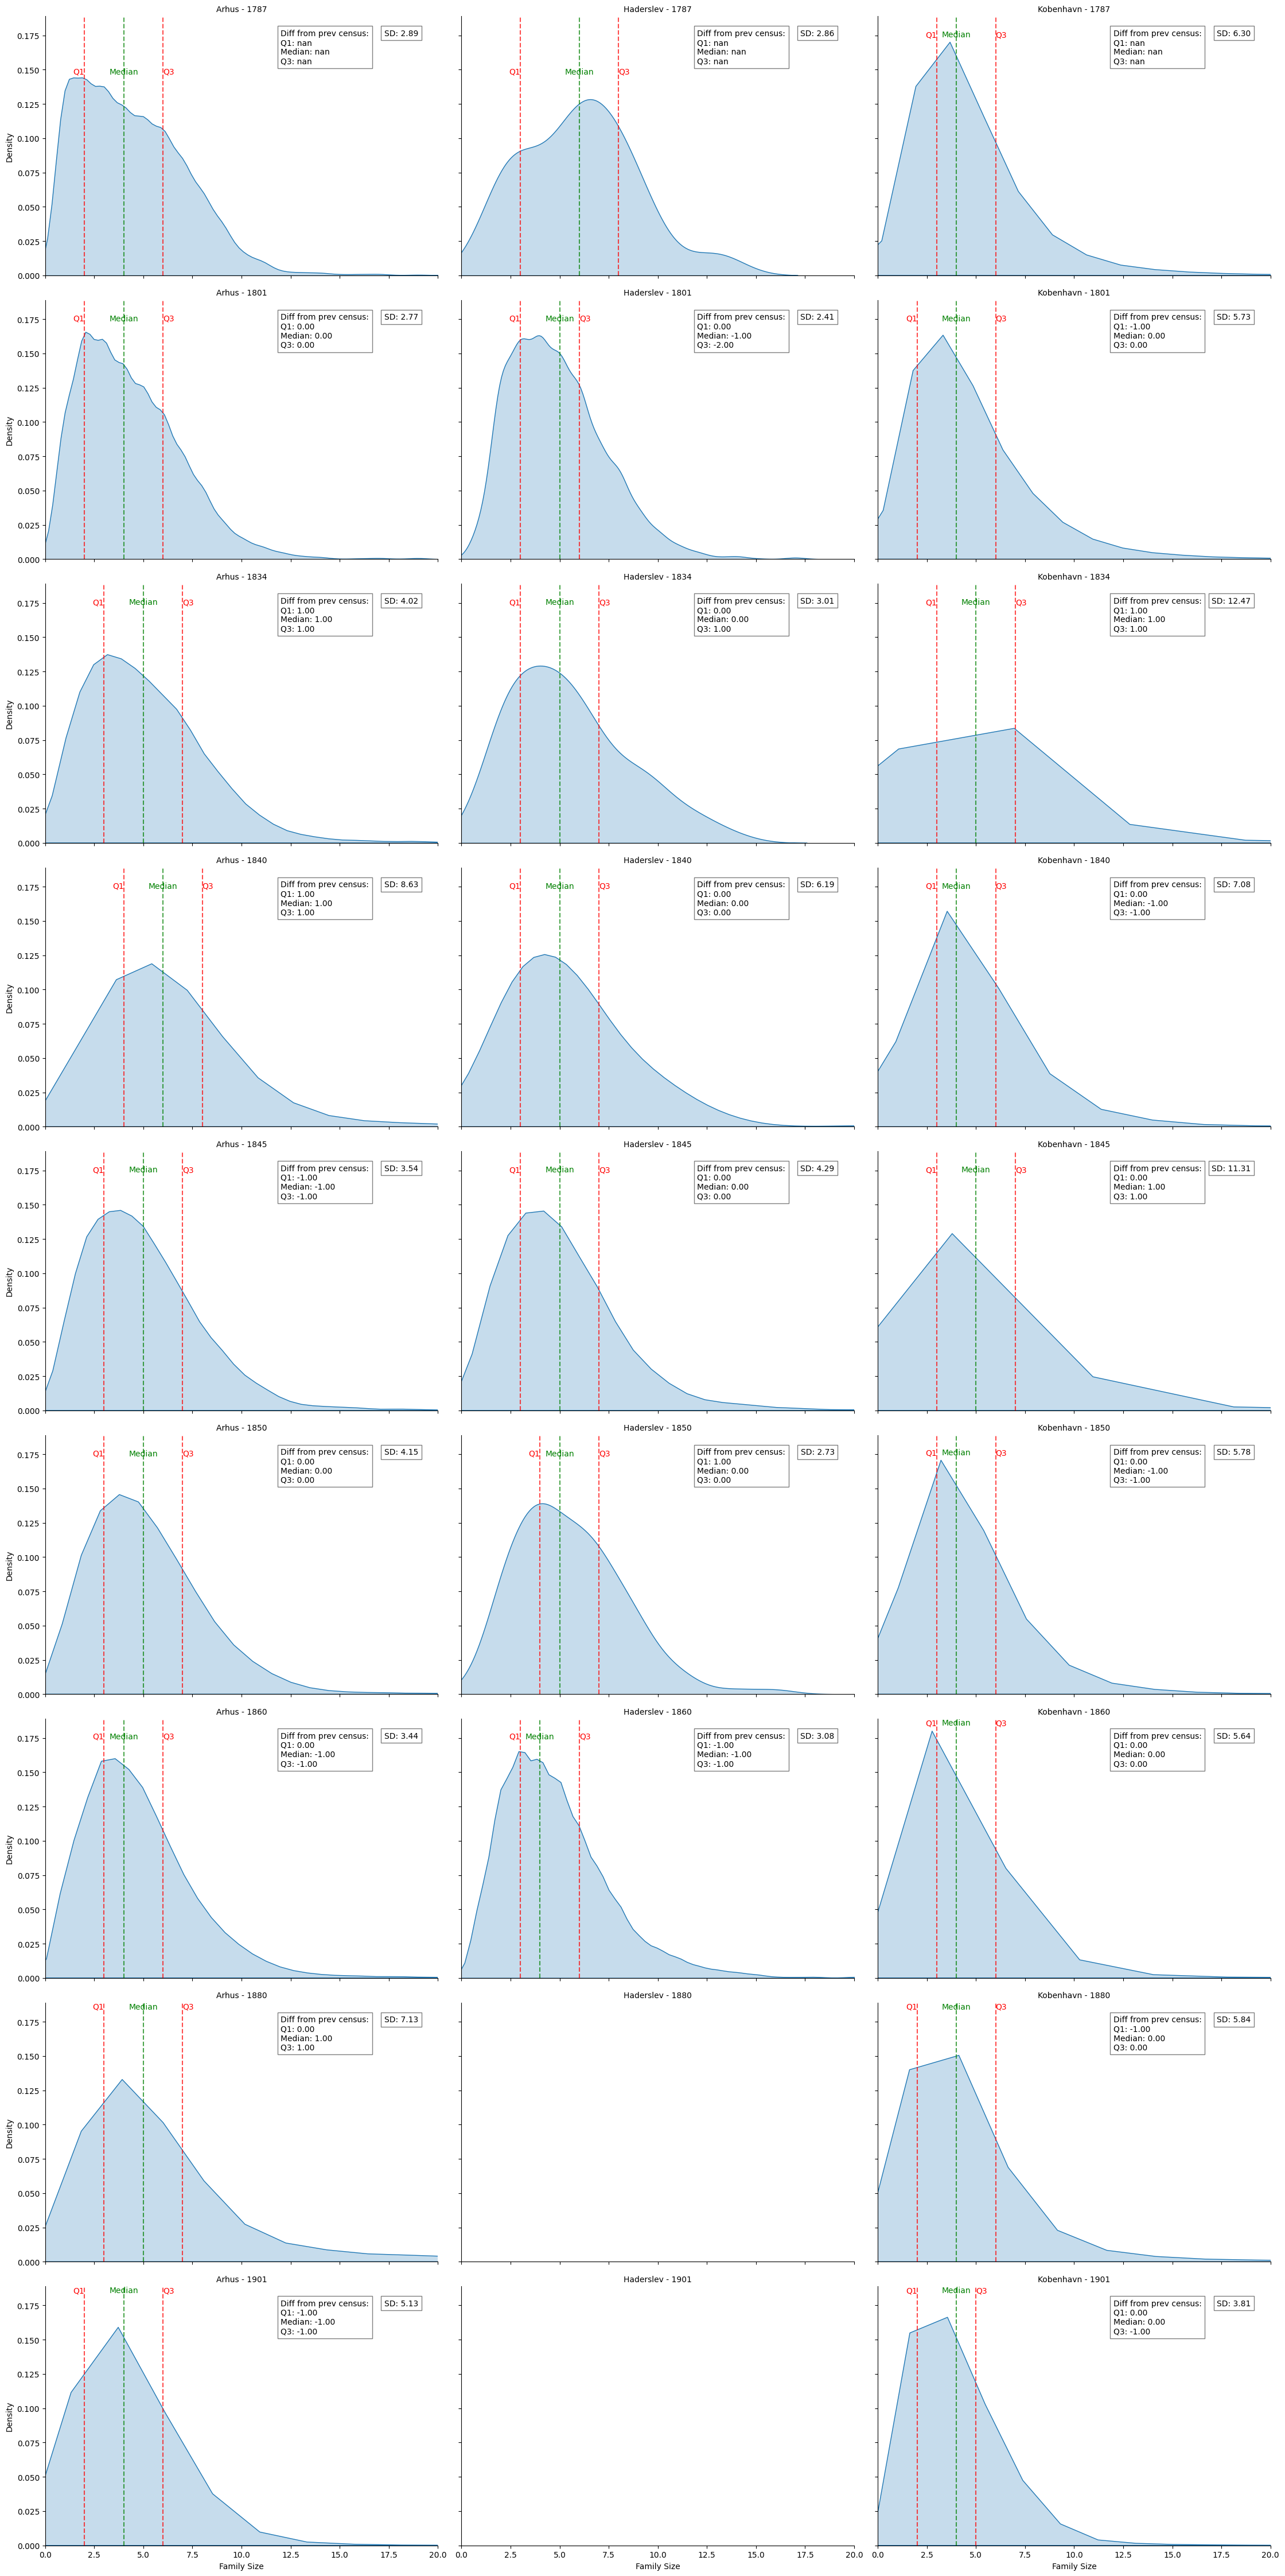

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

csv_files = census_data_dir.glob('*/Rigsarkivet_folketælling*.csv')

def process_file(file_path: Path) -> pd.DataFrame:
    """
    Process a single census file and extract family size information.

    Args:
        file_path (Path): Path to the CSV file.

    Returns:
        pd.DataFrame: Processed data with family sizes, year, and amt.
    """
    if isinstance(file_path, str):
        file_path = Path(file_path)
    df = pd.read_csv(file_path, delimiter='$')
    year = int(str(file_path.stem).split('_')[-1].split('.')[0])
    amt = str(file_path.stem).split('_')[2]
    family_sizes = df.groupby('household_id').size().reset_index(name='family_size')
    family_sizes['year'] = year
    family_sizes['amt'] = amt
    return family_sizes

all_family_sizes = pd.concat([process_file(file) for file in csv_files])

# Calculate statistics for all years and amt
stats = all_family_sizes.groupby(['year', 'amt'])['family_size'].agg(['mean', 'std', 'median', 
                                                                      lambda x: x.quantile(0.25),
                                                                      lambda x: x.quantile(0.75)])
stats.columns = ['mean', 'std', 'median', 'Q1', 'Q3']
stats = stats.reset_index()

# Calculate differences with previous year
stats = stats.sort_values(['amt', 'year'])
stats[['Q1_diff', 'median_diff', 'Q3_diff']] = stats.groupby('amt')[['Q1', 'median', 'Q3']].diff()

def plot_kde_with_stats(**kwargs):
    """
    Plot KDE with additional statistics.

    Args:
        **kwargs: Keyword arguments passed by FacetGrid.map()
    """
    data = kwargs.pop('data')
    x = kwargs.pop('x')
    
    ax = plt.gca()
    sns.kdeplot(data=data, x=x, fill=True, **kwargs)
    
    # Get current year and amt
    year = data['year'].iloc[0]
    amt = data['amt'].iloc[0]
    
    # Get statistics for current year
    current_stats = stats[(stats['year'] == year) & (stats['amt'] == amt)].iloc[0]
    
    # Calculate statistics
    mean, std = current_stats['mean'], current_stats['std']
    q1, median, q3 = current_stats['Q1'], current_stats['median'], current_stats['Q3']
    
    # Add quartile lines
    ax.axvline(q1, color='red', linestyle='--', alpha=0.7)
    ax.axvline(median, color='green', linestyle='--', alpha=0.7)
    ax.axvline(q3, color='red', linestyle='--', alpha=0.7)
    
    # Add text for standard deviation
    ax.text(0.95, 0.95, f'SD: {std:.2f}', transform=ax.transAxes, 
            ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5))

    # Add legend for quartile lines
    ax.text(q1, ax.get_ylim()[1], 'Q1', color='red', ha='right', va='top')
    ax.text(median, ax.get_ylim()[1], 'Median', color='green', ha='center', va='top')
    ax.text(q3, ax.get_ylim()[1], 'Q3', color='red', ha='left', va='top')
    
    # Add box with differences from previous year
    diff_text = (f"Diff from prev census:\n"
                 f"Q1: {current_stats['Q1_diff']:.2f}\n"
                 f"Median: {current_stats['median_diff']:.2f}\n"
                 f"Q3: {current_stats['Q3_diff']:.2f}")
    ax.text(0.60, 0.95, diff_text, transform=ax.transAxes, 
            ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Create the facet plot
g = sns.FacetGrid(all_family_sizes, col="amt", row="year", height=5, aspect=1.5)
g.map_dataframe(plot_kde_with_stats, x="family_size")
g.set(xlim=(0, 20))
g.set_axis_labels("Family Size", "Density")
g.set_titles("{col_name} - {row_name}")

# Adjust layout and display
plt.tight_layout()
plt.show()

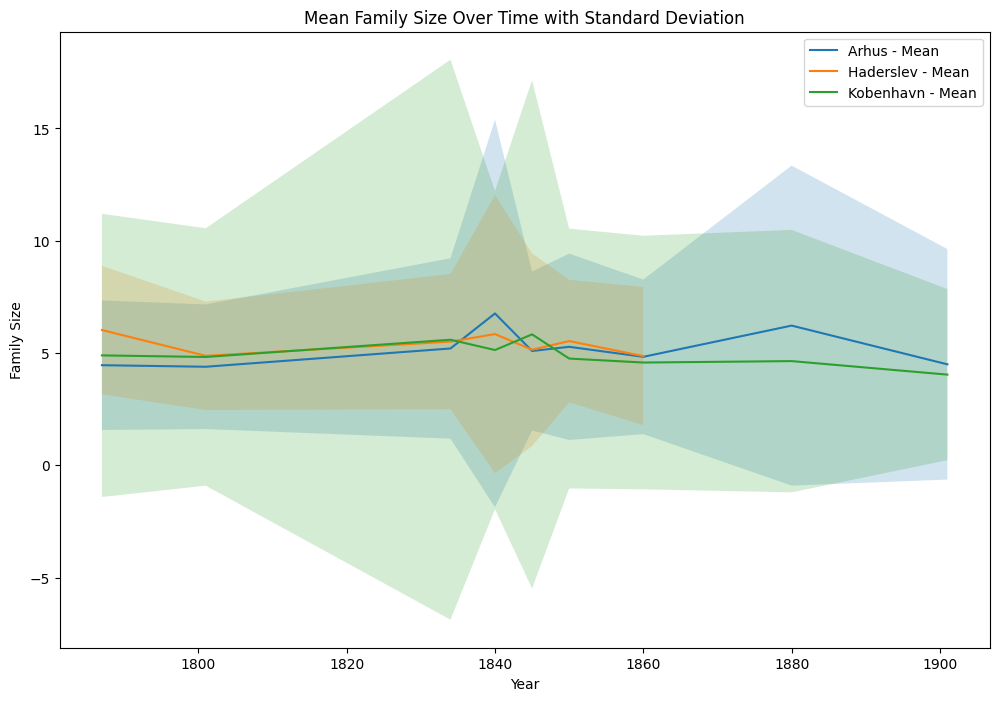

In [7]:
# Assuming all_family_sizes is your main DataFrame
summary_stats = all_family_sizes.groupby(['year', 'amt'])['family_size'].agg(['mean', 'median', 'std'])
summary_stats = summary_stats.reset_index()

plt.figure(figsize=(12, 8))
for amt in summary_stats['amt'].unique():
    amt_data = summary_stats[summary_stats['amt'] == amt]
    plt.plot(amt_data['year'], amt_data['mean'], label=f'{amt} - Mean')
    plt.fill_between(amt_data['year'], 
                     amt_data['mean'] - amt_data['std'], 
                     amt_data['mean'] + amt_data['std'], 
                     alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Family Size')
plt.title('Mean Family Size Over Time with Standard Deviation')
plt.legend()
plt.show()

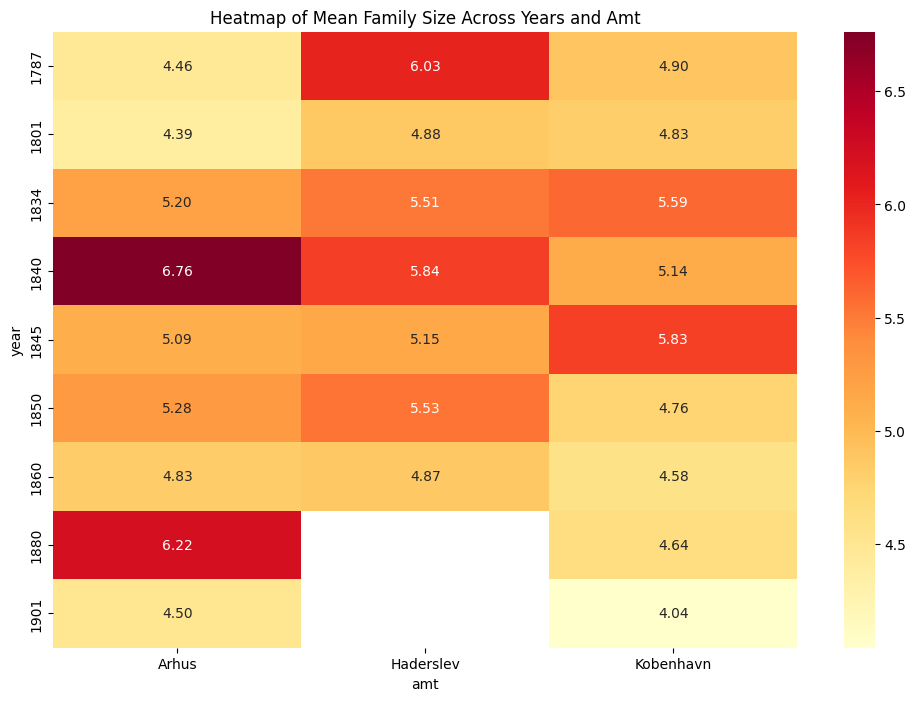

In [8]:
pivot_data = all_family_sizes.pivot_table(values='family_size', 
                                          index='year', 
                                          columns='amt', 
                                          aggfunc='mean')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Heatmap of Mean Family Size Across Years and Amt')
plt.show()

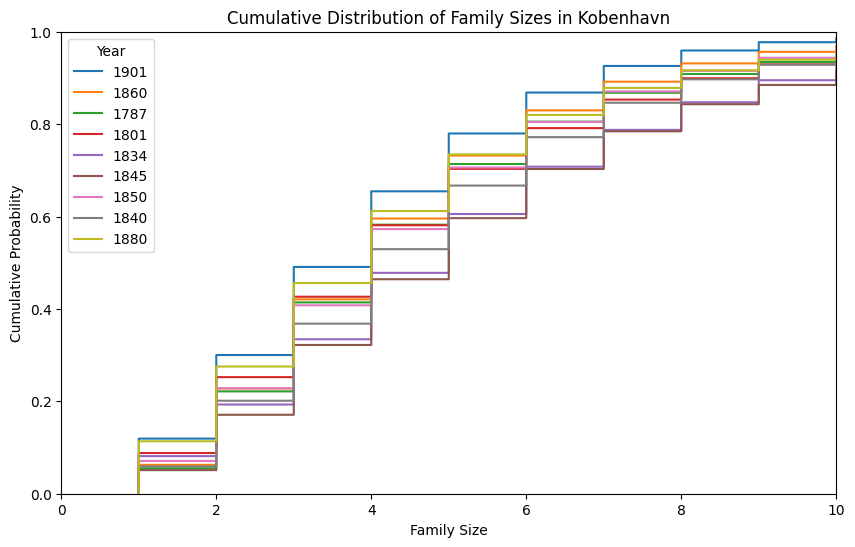

In [9]:
def plot_cdf_by_year(data, amt):
    plt.figure(figsize=(10, 6))
    for year in data['year'].unique():
        year_data = data[(data['year'] == year) & (data['amt'] == amt)]
        sns.ecdfplot(data=year_data, x='family_size', label=str(year))
    
    plt.title(f'Cumulative Distribution of Family Sizes in {amt}')
    plt.xlabel('Family Size')
    plt.ylabel('Cumulative Probability')
    plt.xlim(0, 10)
    plt.legend(title='Year')
    plt.show()

# Example usage
plot_cdf_by_year(all_family_sizes, 'Kobenhavn')

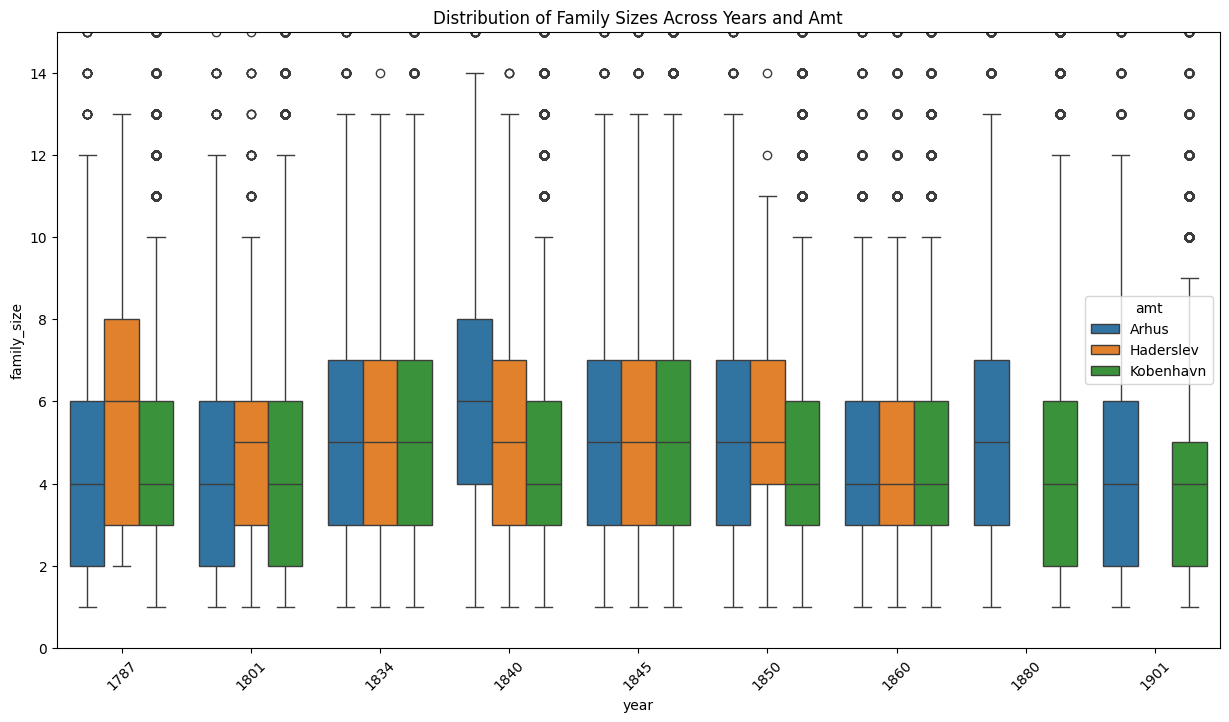

In [10]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='family_size', hue='amt', data=all_family_sizes)
plt.title('Distribution of Family Sizes Across Years and Amt')
plt.xticks(rotation=45)
plt.ylim(0, 15)
plt.show()

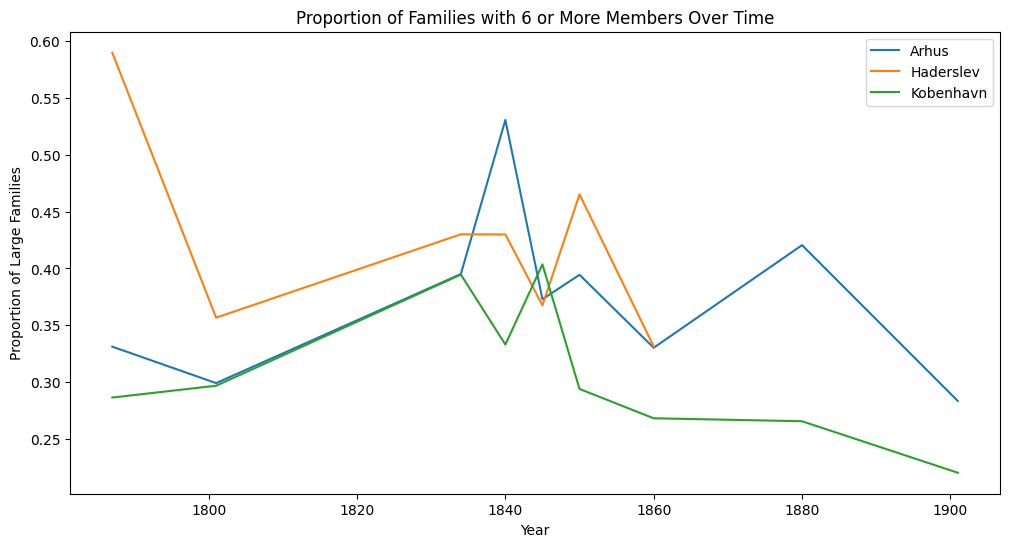

In [11]:
def large_family_proportion(group, threshold=6):
    return (group >= threshold).mean()

large_family_prop = all_family_sizes.groupby(['year', 'amt'])['family_size'].apply(large_family_proportion)
large_family_prop = large_family_prop.reset_index()

plt.figure(figsize=(12, 6))
for amt in large_family_prop['amt'].unique():
    amt_data = large_family_prop[large_family_prop['amt'] == amt]
    plt.plot(amt_data['year'], amt_data['family_size'], label=amt)

plt.xlabel('Year')
plt.ylabel('Proportion of Large Families')
plt.title('Proportion of Families with 6 or More Members Over Time')
plt.legend()
plt.show()

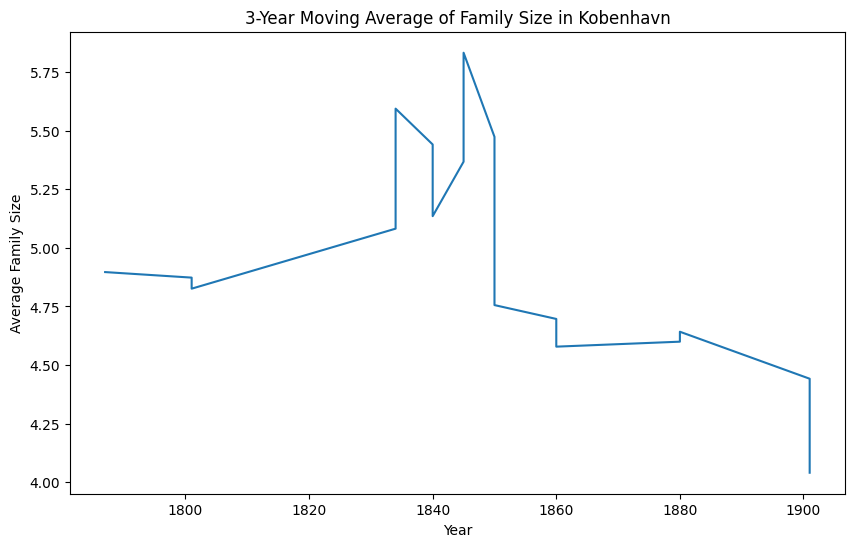

In [12]:
def plot_moving_average(data, amt, window=3):
    amt_data = data[data['amt'] == amt].sort_values('year')
    amt_data['moving_avg'] = amt_data.groupby('year')['family_size'].transform('mean').rolling(window=window).mean()
    
    plt.figure(figsize=(10, 6))
    plt.plot(amt_data['year'], amt_data['moving_avg'])
    plt.title(f'{window}-Year Moving Average of Family Size in {amt}')
    plt.xlabel('Year')
    plt.ylabel('Average Family Size')
    plt.show()

# Example usage
plot_moving_average(all_family_sizes, 'Kobenhavn', window=3)

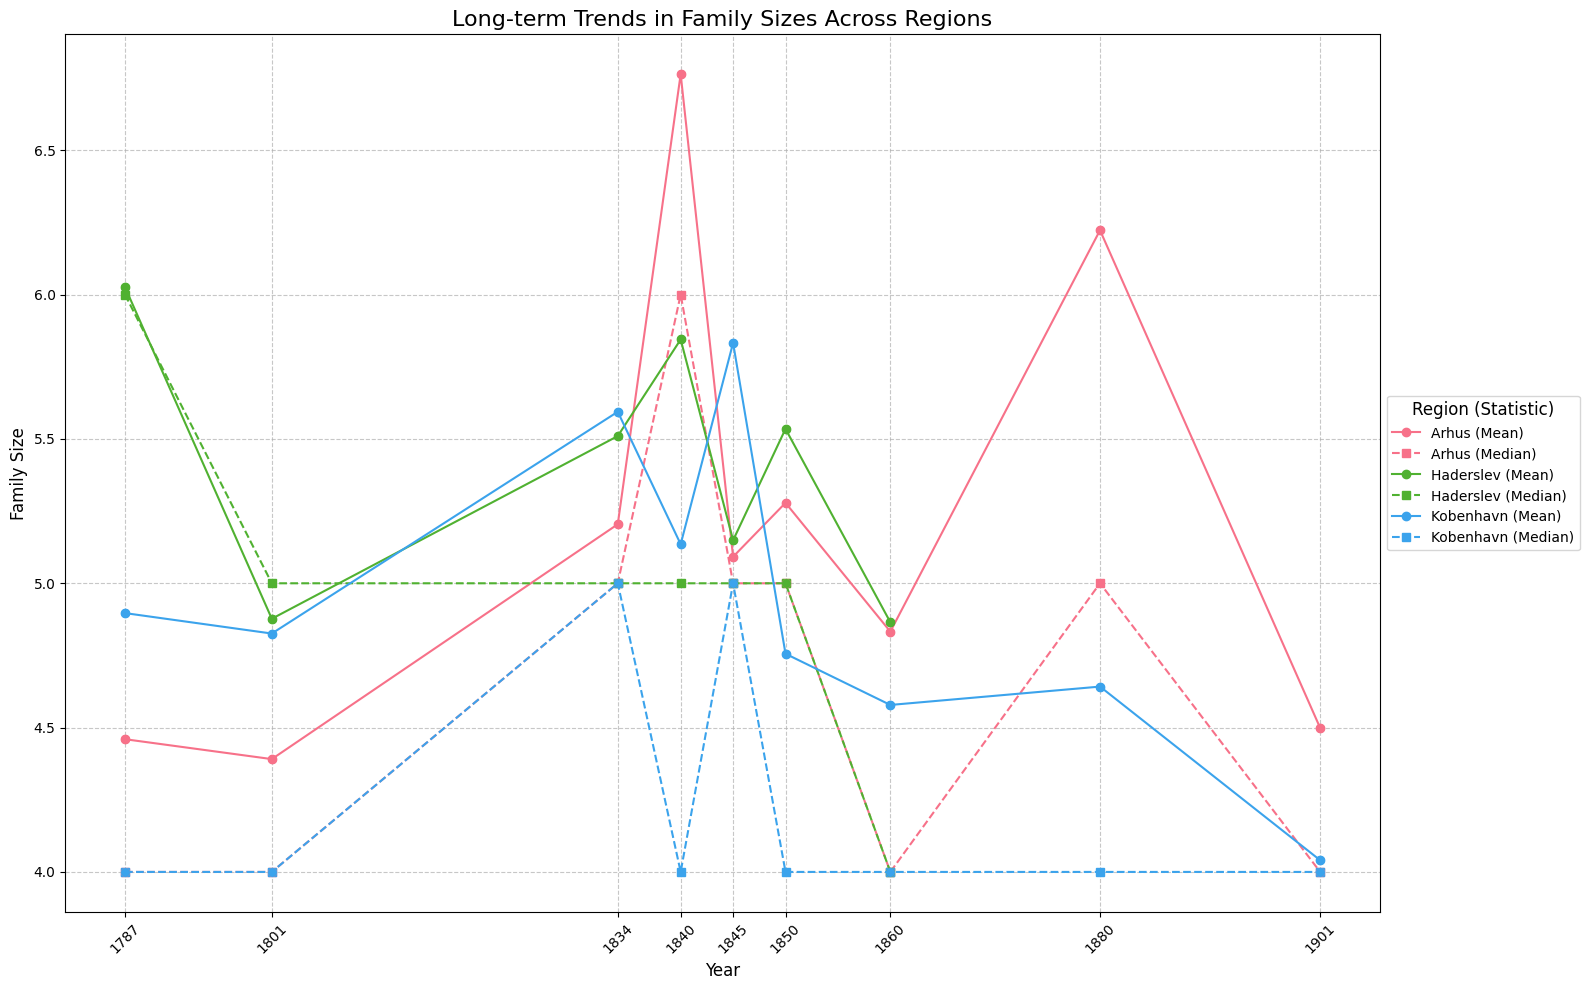

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

def plot_long_term_family_size_trends(data: pd.DataFrame, smooth: bool = False):
    """
    Plot long-term trends in family sizes across different 'amt' (regions).

    Args:
        data (pd.DataFrame): The DataFrame containing family size data.
        smooth (bool): Whether to apply smoothing to the trends. Defaults to True.

    Returns:
        None. Displays the plot.
    """
    # Prepare the data
    grouped_data = data.groupby(['year', 'amt'])['family_size'].agg(['mean', 'median']).reset_index()

    # Set up the plot
    plt.figure(figsize=(16, 10))
    
    # Color palette for different amt
    palette = sns.color_palette("husl", n_colors=len(grouped_data['amt'].unique()))
    
    # Plot for each amt
    for (amt, amt_data), color in zip(grouped_data.groupby('amt'), palette):
        years = amt_data['year']
        mean_sizes = amt_data['mean']
        median_sizes = amt_data['median']
        
        if smooth:
            # Apply smoothing using gaussian_kde
            kde = gaussian_kde(years, bw_method=0.3)
            x_range = np.linspace(years.min(), years.max(), 100)
            smoothed_mean = kde.evaluate(x_range)
            smoothed_mean = smoothed_mean * (mean_sizes.max() / smoothed_mean.max())
            
            plt.plot(x_range, smoothed_mean, label=f'{amt} (Mean)', color=color, linewidth=2)
            plt.plot(years, median_sizes, label=f'{amt} (Median)', color=color, linestyle='--', alpha=0.7)
        else:
            plt.plot(years, mean_sizes, label=f'{amt} (Mean)', color=color, marker='o')
            plt.plot(years, median_sizes, label=f'{amt} (Median)', color=color, linestyle='--', marker='s')

        # Add points for actual data years
        plt.scatter(years, mean_sizes, color=color, s=30, zorder=5)
        plt.scatter(years, median_sizes, color=color, s=30, zorder=5)

    # Customize the plot
    plt.title('Long-term Trends in Family Sizes Across Regions', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Family Size', fontsize=12)
    plt.legend(title='Region (Statistic)', title_fontsize='12', fontsize='10', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust x-axis to show all years
    plt.xticks(sorted(grouped_data['year'].unique()), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_long_term_family_size_trends(all_family_sizes)

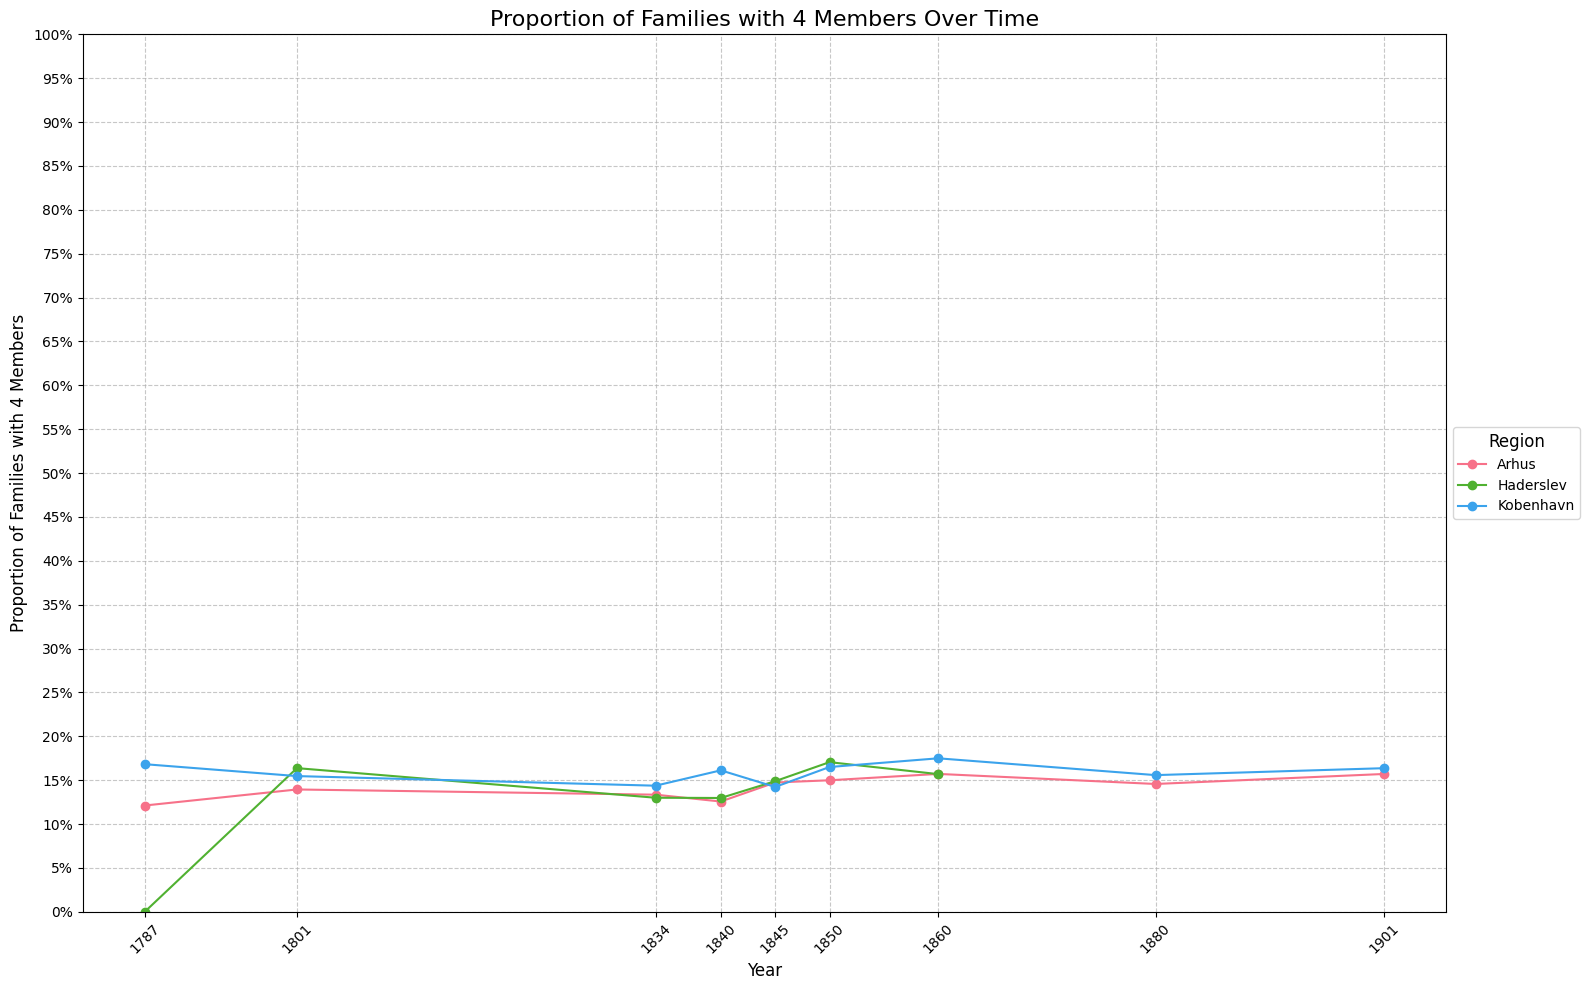

In [19]:
def plot_nuclear_family_proportion(data: pd.DataFrame, family_size: int = 4):
    """
    Plot the proportion of families with a specific size (default 4) over time for each region.

    Args:
        data (pd.DataFrame): The DataFrame containing family size data.
        family_size (int): The family size to consider (default is 4 for nuclear families).

    Returns:
        None. Displays the plot.
    """
    # Calculate the proportion of families with the specified size
    def proportion_of_size(group):
        return (group == family_size).mean()

    proportions = data.groupby(['year', 'amt'])['family_size'].apply(proportion_of_size).reset_index()
    proportions.columns = ['year', 'amt', 'proportion']

    # Set up the plot
    plt.figure(figsize=(16, 10))
    
    # Color palette for different amt
    palette = sns.color_palette("husl", n_colors=len(proportions['amt'].unique()))
    
    # Plot for each amt
    for (amt, amt_data), color in zip(proportions.groupby('amt'), palette):
        plt.plot(amt_data['year'], amt_data['proportion'], label=amt, color=color, marker='o')

    # Customize the plot
    plt.title(f'Proportion of Families with {family_size} Members Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f'Proportion of Families with {family_size} Members', fontsize=12)
    plt.legend(title='Region', title_fontsize='12', fontsize='10', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust y-axis to show proportions
    plt.ylim(0, proportions['proportion'].max() * 1.1)  # Add 10% padding at the top
    plt.yticks([i/20 for i in range(21)])  # Show ticks every 0.05
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))  # Format as percentage
    
    # Adjust x-axis to show all years
    plt.xticks(sorted(proportions['year'].unique()), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_nuclear_family_proportion(all_family_sizes, family_size=4)

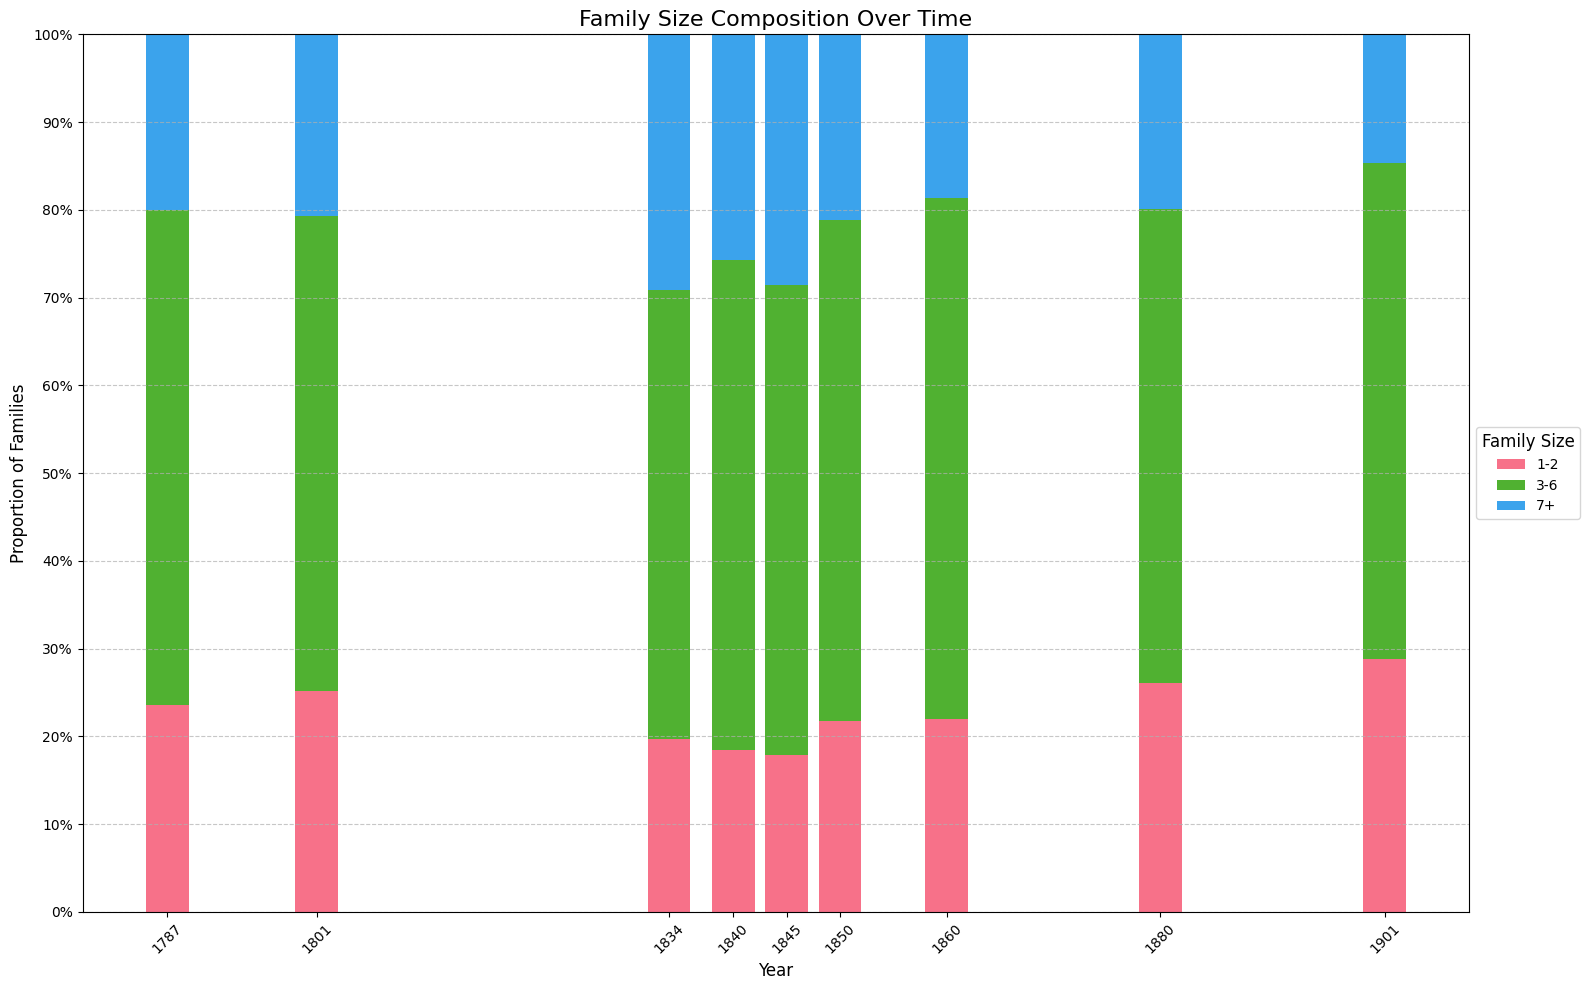

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_family_size_composition(data: pd.DataFrame, bar_width: float = 0.8):
    """
    Create a stacked bar chart showing the proportion of families of different sizes for each year.

    Args:
        data (pd.DataFrame): The DataFrame containing family size data.
        bar_width (float): Width of each bar in the chart. Default is 0.8.

    Returns:
        None. Displays the plot.
    """
    # Prepare the data
    def categorize_family_size(size):
        if size <= 2:
            return '1-2'
        elif 3 <= size <= 6:
            return '3-6'
        elif size >= 7:
            return '7+'
        else:
            return str(size)

    data['size_category'] = data['family_size'].apply(categorize_family_size)
    
    # Calculate proportions
    proportions = data.groupby(['year', 'size_category']).size().unstack(fill_value=0)
    proportions = proportions.div(proportions.sum(axis=1), axis=0)
    
    # Ensure all categories are present
    all_categories = ['1-2', '3-6', '7+']
    for cat in all_categories:
        if cat not in proportions.columns:
            proportions[cat] = 0
    proportions = proportions[all_categories]

    # Set up the plot
    plt.figure(figsize=(16, 10))
    
    # Create the stacked bar chart
    bottom = np.zeros(len(proportions))
    
    # Color palette
    colors = sns.color_palette("husl", n_colors=len(all_categories))
    
    for i, col in enumerate(proportions.columns):
        plt.bar(proportions.index, proportions[col], bottom=bottom, label=col, color=colors[i], width=bar_width)
        bottom += proportions[col]

    # Customize the plot
    plt.title('Family Size Composition Over Time', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Proportion of Families', fontsize=12)
    plt.legend(title='Family Size', title_fontsize='12', fontsize='10', loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True, linestyle='--', alpha=0.7, axis='y')
    
    # Adjust y-axis to show proportions
    plt.ylim(0, 1)
    plt.yticks([i/10 for i in range(11)])
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    # Adjust x-axis to show all years
    plt.xticks(proportions.index, rotation=45)
    
    plt.tight_layout()
    plt.show()

# Usage
plot_family_size_composition(all_family_sizes, bar_width=4)